Rented Bike Count - Upper outliers:
 2946    2401
2994    2402
3114    2401
3210    2404
3282    2692
        ... 
7746    2631
7818    2613
7842    2415
7866    2612
7890    2632
Name: Rented Bike Count, Length: 158, dtype: int64


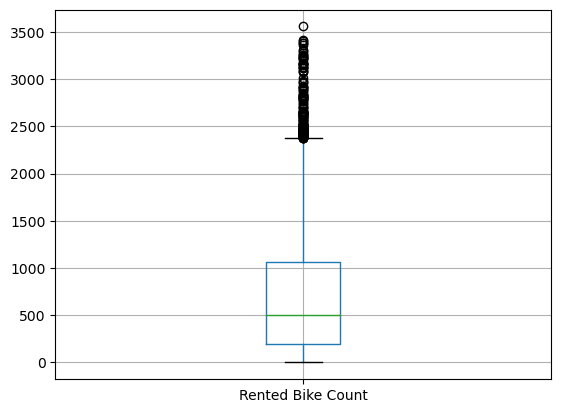

Rented Bike Count - Upper outliers:
 3186    2359
3474    2318
3690    2310
3927    2329
3930    2338
        ... 
6883    2365
7193    2349
7194    2339
8082    2314
8154    2357
Name: Rented Bike Count, Length: 63, dtype: int64


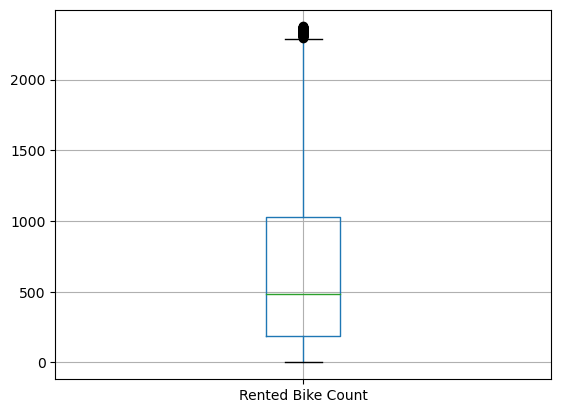

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Helper function
def findMinMax(data):
  q1 = data.quantile(0.25)
  q3 = data.quantile(0.75)
  min = q1 - 1.5 * (q3 - q1)
  max = q3 + 1.5 * (q3 - q1)
  return min, max

# Function to help us visualize the outliers. Produce boxplot and print out outliers
def getOutliers(data, features):
  for i, feature in enumerate(features, 1):
    plt.subplot(1,len(features),i)
    data[[feature]].boxplot()
    
    min, max = findMinMax(data[feature])
    outliers_lower = data[feature] < min
    outliers_upper = data[feature] > max
    
    if outliers_lower.any():
      print(feature, "- Lower outliers:\n", data.loc[outliers_lower, feature])
    if outliers_upper.any():
      print(feature, "- Upper outliers:\n", data.loc[outliers_upper, feature])

  plt.show()
  

# return az set of data with outliers removed
def removeOutliers(data, features):
  removeIdx = pd.Series([False] * len(data))
  for i, feature in enumerate(features):
    min, max = findMinMax(data[feature])
    outliers_lower = data[feature] < min
    outliers_upper = data[feature] > max
    
    removeIdx = removeIdx | outliers_lower | outliers_upper

  return data.loc[~removeIdx]
  


# Testing code
data = pd.DataFrame(pd.read_csv('./SeoulBikeData.csv'))
features = ['Rented Bike Count']

getOutliers(data, features)

newY = removeOutliers(data, features)
getOutliers(newY, features)

In [ ]:
from sklearn.preprocessing import StandardScaler

data = pd.DataFrame(pd.read_csv('./SeoulBikeData.csv'))

# Remove rows with non-functioning day / no bike rented
functioningDay = data['Functioning Day'] == 'Yes'
data = data.loc[functioningDay]

# Dropping some features:
# Date: can't process and we already have the holiday feature
# Dew temp: not relevant
# Functioning day: already process
data = data.drop(columns=['Date', 'Dew point temperature', 'Functioning Day'])


# One Hot Encode categorical features
# Hour should be categorical too. Not sure how to handle it yet
data = pd.get_dummies(data, columns=['Seasons'], dtype=int)
data = pd.get_dummies(data, columns=['Holiday'], dtype=int, drop_first=True)


getOutliers(data, ['Rented Bike Count', 'Temperature', 'Humidity', 'Wind speed', 'Visibility', 'Solar Radiation', 'Rainfall', 'Snowfall'])

# It seems like every rainy or snowy days are counted as outliers because the weather is normal most of the time.
# Therefore, not going to remove outliers for Rainfall and Snowfall

# A lot of outliers for Solar Radiation. We can test this out with our models. For now, not removing outliers for this one

# Around 150 outliers for Rented Bike Count and Wind Speed. Remove outliers for now

data = removeOutliers(data, ['Rented Bike Count', 'Temperature', 'Humidity', 'Wind speed', 'Visibility'])
data = data.reset_index(drop=True)
print(data)


# Splitting data between categorical and numericals set for standardization
categoricalFeatures = ['Hour', 'Seasons_Autumn', 'Seasons_Spring', 'Seasons_Summer', 'Seasons_Winter', 'Holiday_No Holiday']
numericalFeatures = ['Rented Bike Count', 'Temperature', 'Humidity', 'Wind speed', 'Visibility', 'Solar Radiation', 'Rainfall', 'Snowfall']
categoricalValues = data[categoricalFeatures]
standardizedData = data.drop(columns=categoricalFeatures)

scaler = StandardScaler()
scaler.fit(standardizedData)
standardizedData = scaler.transform(standardizedData)
standardizedData = pd.DataFrame(standardizedData)
standardizedData.columns = numericalFeatures

standardizedData = pd.concat([standardizedData, categoricalValues], axis=1)
print(standardizedData)

[-1.3506792052531011, -7.972236397318641, -0.1891162329617484, 0.5772838869130781, 0.6467936106547856, 0.5434133252633591, 0.3511658289517351, 0.5986659412335449, 0.6216049287553728, 0.553735269079039]
-0.5619369044682576


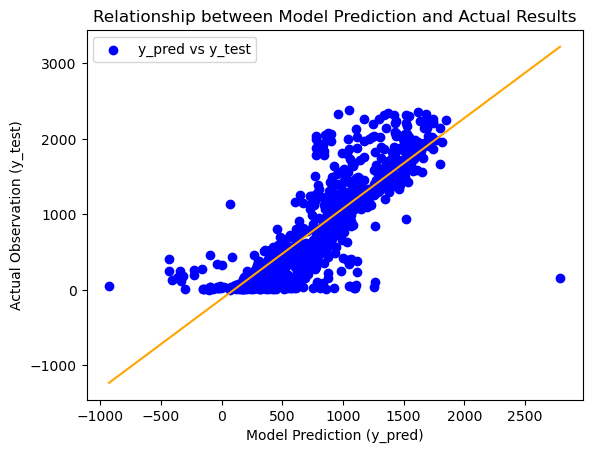

MSE of Model:  157163.99124661877
R^2 of Model:  0.6467936106547856


In [83]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

def linear_regression(X, y, random_state=None):
    seed = 185
    degree = 2 # 1, 2, 3
    batch_size = 8 # 8, 16, 32
    regularization_term = 0.0001 # 0.001, 0.01
    # Define type of penalty
    penalty_type = "l2"
    folds = 10
    # Define number of folds for cross-validation
    kf = KFold(folds)
    # Set Randomness for Reproducibility
    np.random.seed(seed)
    # Perform Polynomial Transformation
    poly_features = PolynomialFeatures(degree)
    X_poly = poly_features.fit_transform(X)
    
    model_results = []
    r_squares = []
    # Split into k_folds
    for train_index, test_index in kf.split(X_poly):
        # Split data into training and testing sets for this fold
        X_train, X_test = X_poly[train_index], X_poly[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        model = LinearRegression()
        model.fit(X_train, y_train)
    
#         # Perform BGD Fit polynomial regression model
#         model = SGDRegressor(learning_rate="constant", eta0=0.00001, 
#                              random_state=seed, alpha=regularization_term, penalty=penalty_type)
#         epochs = 30
#         m = X_train.shape[0]
#         for epoch in range(epochs):
#             num_batches = m // batch_size if batch_size else 1
#             # Iterate over the batches in each epoch
#             for batch in range(num_batches):
#                 # If a batch_size is provided, it means to perform mini-batch gradient descent, where the training dataset is divided into smaller batches, and each batch is used to update the model's parameters.
#                 if batch_size:
#                     #This line generates random indices from 0 to m (the total number of samples in the training set) without replacement. m is the size of the training dataset. The number of indices generated is equal to the batch_size.
#                     indices = np.random.choice(m, batch_size)
#                     # creates a mini-batch of input features for training
#                     X_batch = X_train[indices]
#                     # selects the corresponding subset of y for the mini-batch of input features
#                     y_batch = y_train[indices]
#                 else:
#                     # performing full-batch-gradient descent 
#                     X_batch = X_train
#                     y_batch = y_train
#                 model.partial_fit(X_batch, y_batch)

        # Obtain the predictions on the test data
        y_pred = model.predict(X_test)
        
        # store mse score of the model applied on the test data
        mse = mean_squared_error(y_test, y_pred)
        r_square = r2_score(y_test, y_pred)
        
        r_squares.append(r_square)
        model_results.append([model, mse, r_square, y_pred, y_test])
    
    # print the total_error of the best model
    best_model_index = np.argmax(r_squares)
    
    print(r_squares)
    print(np.mean(r_squares))
    
    return model_results[best_model_index]


# Loud the housing dataset
all_data = pd.DataFrame(pd.read_csv('./ProcessedData.csv'))
X = all_data.drop(columns=['Rented Bike Count', 'Seasons_Autumn', 
                           'Seasons_Spring', 'Seasons_Summer', 'Seasons_Winter', 'Holiday_No Holiday', 'Solar Radiation', 'Snowfall'])
# Set the target variable
y = all_data['Rented Bike Count'].ravel()
# Perform Batch Gradient Descent
model, mse, r_square, y_pred, y_test = linear_regression(X, y)
# Plot y_pred vs y_test
plt.scatter(y_pred, y_test, color='blue', label='y_pred vs y_test')  # Plot original data points

# Fit a first-degree polynomial (i.e., a straight line) to the data
coefficients = np.polyfit(y_pred, y_test, 1)
poly = np.poly1d(coefficients)

# Create a range of x values to plot the line
x_line = np.linspace(y_pred.min(), y_pred.max(), 100)

# Plot the line of best fit
plt.plot(x_line, poly(x_line), color='orange')
plt.title('Relationship between Model Prediction and Actual Results')
plt.xlabel('Model Prediction (y_pred)')
plt.ylabel('Actual Observation (y_test)')
plt.legend()
plt.show()
print("MSE of Model: ", mse)
print("R^2 of Model: ", r_square)

# save
# joblib.dump(clf, "model.pkl") 

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# not sure if this function is totally necessary because it runs without it
def bgd(X, y, learning_rate=0.01, batch_size=32, reg_para=0.01, epochs=100, clip_value=5.0):
    
    n_samples, n_features = X.shape
    
    # Initialize weights with small random values
    weights = np.random.randn(n_features) * 0.01
    bias = 0
    loss_history = []
    
    # Calculate number of batches
    n_batches = int(np.ceil(n_samples / batch_size))
    
    for epoch in range(epochs):
        indices = np.random.permutation(n_samples)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        epoch_loss = 0
        
        for batch in range(n_batches):
            start_idx = batch * batch_size
            end_idx = min((batch + 1) * batch_size, n_samples)
            X_batch = X_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx]
            batch_size_actual = end_idx - start_idx
            
            # Forward pass with numerical stability
            y_pred = np.clip(np.dot(X_batch, weights) + bias, -1e15, 1e15)
            
            # Calculate gradients with numerical stability
            errors = y_pred - y_batch
            dw = (1/batch_size_actual) * (np.dot(X_batch.T, errors) + reg_para * weights)
            db = np.mean(errors)
            
            # Gradient clipping
            dw = np.clip(dw, -clip_value, clip_value)
            db = np.clip(db, -clip_value, clip_value)
            
            # Update weights and bias with smaller learning rate
            weights -= learning_rate * dw
            bias -= learning_rate * db
            
            # Calculate loss with numerical stability
            squared_errors = np.clip(errors ** 2, 0, 1e15)
            batch_loss = np.mean(squared_errors) + (reg_para/(2*batch_size_actual)) * np.sum(np.clip(weights ** 2, 0, 1e15))
            epoch_loss += batch_loss
            
            # Check for NaN values
            if np.isnan(batch_loss) or np.isnan(weights).any():
                print(f"NaN detected at epoch {epoch}, batch {batch}. Stopping training.")
                return weights, bias, loss_history
        
        epoch_loss /= n_batches
        loss_history.append(epoch_loss)
        
        # Early stopping if loss is very small
        if epoch > 0 and abs(loss_history[-1] - loss_history[-2]) < 1e-7:
            break
            
    return weights, bias, loss_history


def predict_batch_gd(X, weights, bias):
    # prevent overflow
    return np.clip(np.dot(X, weights) + bias, -1e15, 1e15)

# batch gradient descent with l2 regularization
def grid_search_bgd(X, y, folds=10, degrees=[1, 2], 
                   batch_sizes=[32, 64],
                   learning_rates=[0.00001, 0.0001], 
                   reg_parameters=[0.00001, 0.0001]):
    
    # store best results
    best_mse = float('inf')
    best_params = None
    best_weights = None
    best_bias = None

    # need to convert to numpy arrays for compatibility w sklearn
    X_np = X.to_numpy() if hasattr(X, 'to_numpy') else X
    y_np = y.to_numpy() if hasattr(y, 'to_numpy') else y
    
    # scale y to prevent overflow
    y_scale = np.max(np.abs(y_np))
    y_np = y_np / y_scale
    
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    results = []
    
    for degree in degrees:
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_poly = poly.fit_transform(X_np)
        
        # scale X to prevent overflow
        X_scale = np.max(np.abs(X_poly))
        X_poly = X_poly / X_scale
        
        for batch_size in batch_sizes:
            for learning_rate in learning_rates:
                for reg_para in reg_parameters:
                    
                    fold_mses = []
                    
                    for train_index, val_index in kf.split(X_poly):
                        X_train, X_val = X_poly[train_index], X_poly[val_index]
                        y_train, y_val = y_np[train_index], y_np[val_index]
                        
                        try:
                            weights, bias, loss_history = bgd(
                                X_train, y_train,
                                learning_rate=learning_rate,
                                batch_size=batch_size,
                                reg_para=reg_para
                            )
                            
                            y_pred = predict_batch_gd(X_val, weights, bias)
                            
                            # Scale predictions back
                            y_pred = y_pred * y_scale
                            y_val_original = y_val * y_scale
                            
                            mse = mean_squared_error(y_val_original, y_pred)
                            fold_mses.append(mse)
                        except Exception as e:
                            print(f"Error in fold: {str(e)}")
                            continue
                    
                    if fold_mses:  # only if we have valid results
                        avg_mse = np.mean(fold_mses)
                        
                        results.append({
                            'degree': degree,
                            'batch_size': batch_size,
                            'learning_rate': learning_rate,
                            'reg_para': reg_para,
                            'mse': avg_mse
                        })
                        
                        if avg_mse < best_mse:
                            best_mse = avg_mse
                            best_params = {
                                'degree': degree,
                                'batch_size': batch_size,
                                'learning_rate': learning_rate,
                                'reg_para': reg_para
                            }
                            best_weights = weights * X_scale
                            best_bias = bias * y_scale
    
    if best_params is None:
        raise ValueError("No valid models found. Adjust hyperparameters.")
    
    print("\nBest parameters:")
    for param, value in best_params.items():
        print(f"{param}: {value}")
    print(f"Best Mean Squared Error: {best_mse:.4f}")
    
    return best_weights, best_bias, best_params, results

def plot_training_history(loss_history):
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()



# running code
# Get feature matrix X and target variable y
X = standardizedData.drop('Rented Bike Count', axis=1)
y = standardizedData['Rented Bike Count']

print("Shape of data:")
print("X shape:", X.shape)
print("y shape:", y.shape)

# Define the parameter grid 
param_grid = {
    'degrees': [1, 2],  # Start with linear model
    'batch_sizes': [16, 32, 64],  
    'learning_rates': [0.00001, 0.0001, 0.001],  # Much smaller learning rates
    'reg_parameters': [0.00001, 0.0001, 0.001]  # Smaller regularization parameters
}

# Perform grid search with cross validation
try:
    best_weights, best_bias, best_params, results = grid_search_bgd(
        X, y,
        folds=5,  # Reduced folds for faster testing
        **param_grid
    )

    # Print results summary
    print("\nTraining Results Summary:")
    print("-------------------------")
    for param, value in best_params.items():
        print(f"{param}: {value}")

    # Create predictions using best model
    poly = PolynomialFeatures(degree=best_params['degree'], include_bias=False)
    X_poly = poly.fit_transform(X)
    predictions = predict_batch_gd(X_poly, best_weights, best_bias)

    # Calculate and print final MSE
    final_mse = mean_squared_error(y, predictions)
    print(f"\nFinal MSE on full dataset: {final_mse:.4f}")

    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y, predictions, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    plt.xlabel('Actual Bike Rentals')
    plt.ylabel('Predicted Bike Rentals')
    plt.title('Actual vs Predicted Bike Rentals')
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"An error occurred: {str(e)}")

"""
numpy .clip: https://numpy.org/doc/2.1/reference/generated/numpy.clip.html
numpy .dot: https://numpy.org/doc/2.1/reference/generated/numpy.dot.html

"""